<a href="https://colab.research.google.com/github/siva-sankar-a/eva/blob/master/S11/EVA4_Session_11_super_convergence_with_API.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone "https://github.com/sahalk/eva.git"

Cloning into 'eva'...
remote: Enumerating objects: 281, done.
remote: Counting objects: 100% (281/281), done.
remote: Compressing objects: 100% (216/216), done.
remote: Total 281 (delta 142), reused 193 (delta 60), pack-reused 0
Receiving objects: 100% (281/281), 2.16 MiB | 5.63 MiB/s, done.
Resolving deltas: 100% (142/142), done.


In [2]:
!pip install torchviz

     |████████████████████████████████| 51kB 5.0MB/s 
  Created wheel for torchviz: filename=torchviz-0.0.1-cp36-none-any.whl size=3520 sha256=e28946e425961eac92ae0c331da388f2980114c29ebc0361ff3a4d9dea0bf07d
  Stored in directory: /root/.cache/pip/wheels/2a/c2/c5/b8b4d0f7992c735f6db5bfa3c5f354cf36502037ca2b585667
Successfully built torchviz


In [3]:
import torch
import torchvision
import numpy as np

from torch.nn import functional as F
import matplotlib.pyplot as plt

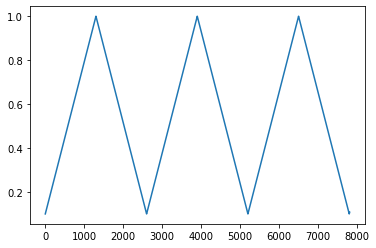

In [4]:
lr_min = 0.1
lr_max = 1.0

n_epochs = 20
batch_size = 128
n_samples = 50000

step_size = 1300

max_iterations = np.floor((n_samples / batch_size) * n_epochs)

iterations = np.arange(0, max_iterations)
cycle = np.floor(1 + (iterations / (2 * step_size)))
x = np.abs((iterations / step_size) - (2 * cycle) + 1)
lr_t = lr_min + (lr_max - lr_min) * (1 - x)

plt.plot(iterations, lr_t)

In [5]:
from eva.Session11.api import Experiment
from eva.Session11.data_manager.data_manager_albumentations import  DataManager
from eva.Session11.utils import textual_summary_cifar10, graphical_summary_cifar10
from eva.Session11.settings import cifar10_classes
from eva.Session11.models.model_s11 import Net
from eva.Session11.grad_cam.grad_cam import GradCam

  pip install torch-lr-finder -v --global-option="amp"


### Create an instance of experiment class

In [6]:
experiment = Experiment(name='default', dataset_name='cifar10')

CUDA status: True


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [7]:
textual_summary_cifar10(experiment.model)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 256,

# LR range test

In [8]:
momentum = 0.9
weight_decay = 0.01
max_lr = 0.25

In [9]:
experiment = Experiment(name='default', dataset_name='cifar10')
experiment.run(epochs=10, momentum=0.9, lr=max_lr, regularization=None, weight_decay=weight_decay, max_lr=max_lr, epochs_up=10, base_momentum=0.85, div_factor=1e6)

CUDA status: True
Files already downloaded and verified
Files already downloaded and verified


TRAIN : epoch=0 train_loss=0.03275 correct/total=19286/50000 lr=0.03 accuracy=38.57: 100%|██████████| 782/782 [00:22<00:00, 34.80it/s]
TEST :  epoch=0 test_loss=2.79588 correct/total=3877/10000 accuracy=38.77: 100%|██████████| 157/157 [00:02<00:00, 76.63it/s]
TRAIN : epoch=1 train_loss=0.02222 correct/total=29201/50000 lr=0.05 accuracy=58.40: 100%|██████████| 782/782 [00:22<00:00, 35.30it/s]
TEST :  epoch=1 test_loss=1.00295 correct/total=6518/10000 accuracy=65.18: 100%|██████████| 157/157 [00:02<00:00, 74.67it/s]
TRAIN : epoch=2 train_loss=0.01303 correct/total=35767/50000 lr=0.08 accuracy=71.53: 100%|██████████| 782/782 [00:21<00:00, 35.74it/s]
TEST :  epoch=2 test_loss=0.66131 correct/total=7810/10000 accuracy=78.10: 100%|██████████| 157/157 [00:02<00:00, 77.08it/s]
TRAIN : epoch=3 train_loss=0.01073 correct/total=38184/50000 lr=0.10 accuracy=76.37: 100%|██████████| 782/782 [00:21<00:00, 35.90it/s]
TEST :  epoch=3 test_loss=0.59950 correct/total=8001/10000 accuracy=80.01: 100%|█████

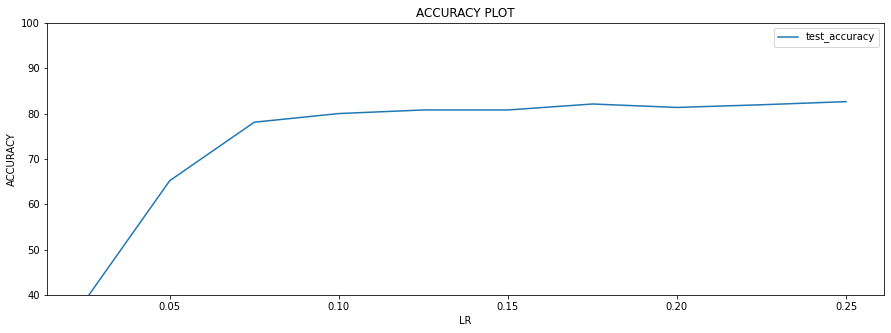

In [12]:
experiment.load_summary()
experiment.plot_lr_range_test_ocp()

Selected max_lr is 0.125 as accuracy stagnates between 0.13 and 0.15

# Training

In [13]:
momentum = 0.9
weight_decay = 0.01
max_lr = 0.125

In [14]:
experiment_ocp = Experiment(name='default', dataset_name='cifar10')

CUDA status: True
Files already downloaded and verified
Files already downloaded and verified


In [20]:
experiment_ocp.run(epochs=10, momentum=0.9, lr=max_lr, regularization=None, weight_decay=weight_decay, max_lr=max_lr, epochs_up=5, base_momentum=0.85, div_factor=10)

TRAIN : epoch=0 train_loss=0.00100 correct/total=48909/50000 lr=0.04 accuracy=97.82: 100%|██████████| 782/782 [00:22<00:00, 35.50it/s]
TEST :  epoch=0 test_loss=0.40944 correct/total=8972/10000 accuracy=89.72: 100%|██████████| 157/157 [00:02<00:00, 76.34it/s]
TRAIN : epoch=1 train_loss=0.00155 correct/total=48319/50000 lr=0.06 accuracy=96.64: 100%|██████████| 782/782 [00:21<00:00, 36.16it/s]
TEST :  epoch=1 test_loss=0.43830 correct/total=8878/10000 accuracy=88.78: 100%|██████████| 157/157 [00:02<00:00, 75.49it/s]
TRAIN : epoch=2 train_loss=0.00212 correct/total=47699/50000 lr=0.08 accuracy=95.40: 100%|██████████| 782/782 [00:21<00:00, 36.16it/s]
TEST :  epoch=2 test_loss=0.45245 correct/total=8818/10000 accuracy=88.18: 100%|██████████| 157/157 [00:02<00:00, 77.36it/s]
TRAIN : epoch=3 train_loss=0.00283 correct/total=46873/50000 lr=0.10 accuracy=93.75: 100%|██████████| 782/782 [00:21<00:00, 36.05it/s]
TEST :  epoch=3 test_loss=0.47065 correct/total=8720/10000 accuracy=87.20: 100%|█████

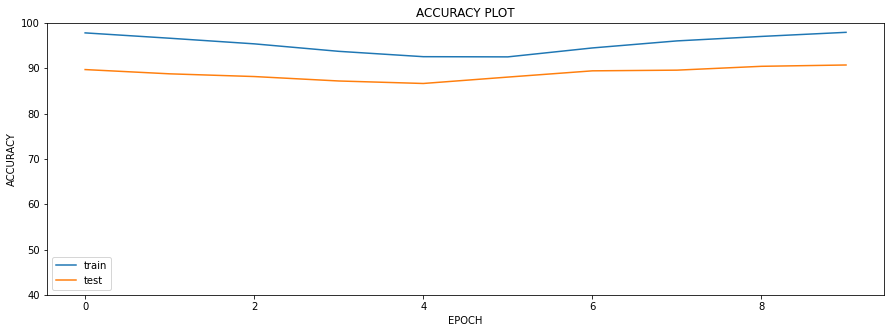

In [21]:
experiment_ocp.load_summary()
experiment_ocp.plot_metric()